In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import pow
import matplotlib.pyplot as plt
import matplotlib.animation as animation  
import math
import os
from sklearn.metrics import r2_score
from ipywidgets import IntProgress
import scipy.optimize as opt
# sns.set_theme()

In [3]:
df = pd.read_csv("Data/Grim/data.csv", index_col=0)

In [4]:
def rrc3_pressure_conversion_function_ft(press_kpa):
    pressure = press_kpa * 10
    altitude = (1 - pow(pressure / 1_013.25, 0.190284)) * 145_366.45
    return altitude


def ft_to_meters(ft): return ft * 0.3048

In [5]:
boost_end = 3_500
first_charge = 28_125

In [6]:
altim = df[['pressure (kPa)']].copy()

In [7]:
altim['alt_m_asl'] = altim['pressure (kPa)'].map(rrc3_pressure_conversion_function_ft).map(ft_to_meters)
altim['alt_m_agl'] = altim['alt_m_asl'] - altim['alt_m_asl'].min()

Text(0.5, 1.0, 'Measured Altimeter Altitude')

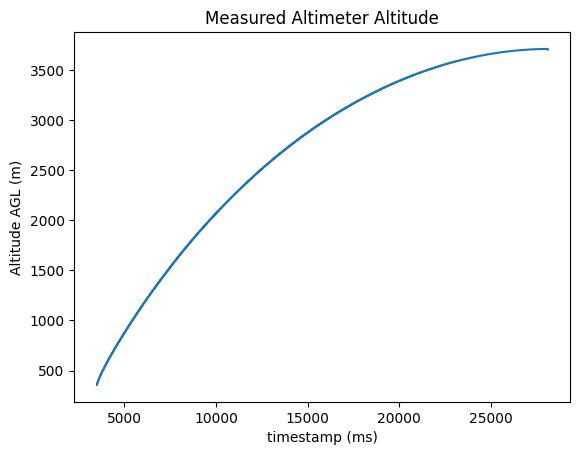

In [8]:
fig = altim.loc[boost_end:first_charge]['alt_m_agl'].plot()
fig.set_ylabel("Altitude AGL (m)")
fig.set_title("Measured Altimeter Altitude")

In [9]:
nice_data = altim.loc[boost_end:first_charge].copy()
nice_data.index = nice_data.index.to_series() / 1000.0
nice_data.index.set_names("timestamp", inplace=True)

In [10]:
nice_data['t'] = nice_data.index

In [11]:
nice_data

,pressure (kPa),alt_m_asl,alt_m_agl,t
timestamp,,,,
3.502,83.018967,1648.553042,356.325308,3.502
3.506,83.018967,1648.553042,356.325308,3.506
3.509,82.812447,1668.766340,376.538606,3.509
3.513,82.812447,1668.766340,376.538606,3.513
3.516,82.812447,1668.766340,376.538606,3.516
...,...,...,...,...
28.109,54.010750,4999.179527,3706.951794,28.109
28.113,54.010750,4999.179527,3706.951794,28.113
28.116,54.010750,4999.179527,3706.951794,28.116


In [12]:
actual_apogee, actual_apogee_index = nice_data['alt_m_agl'].max(), nice_data['alt_m_agl'].argmax() 
actual_apogee_time = nice_data.iloc[actual_apogee_index].t
print(actual_apogee, actual_apogee_time)

3712.8837039159207 28.056


In [34]:

def curve_fit_to_now(row):
    endt = row.name
    data = nice_data[:endt]

    poly = np.polyfit(data.index, data['alt_m_agl'], 2)
    predictor = np.poly1d(poly)
    outs = predictor(nice_data.index)
    predicted_apogee, predicted_apogee_index = outs.max(), outs.argmax()
    predicted_apogee_time = nice_data.iloc[predicted_apogee_index].name
    # print(time_difference)
    if predicted_apogee > 10_000:
        predicted_apogee = 10_000
    elif predicted_apogee < 0:
        return 0
    pred_alt = predictor(endt)
    return pred_alt, predicted_apogee, predicted_apogee_time, poly[0], poly[1], poly[2]

In [35]:
fdata = nice_data.copy()

In [38]:
fdata[['pred_alt', 'pred_apogee', 'pred_apogee_t', 'e0', 'e1', 'e2']] = fdata.apply(curve_fit_to_now, axis=1, result_type='expand')

/tmp/ipykernel_44175/3293187118.py:5: RankWarning: Polyfit may be poorly conditioned
  poly = np.polyfit(data.index, data['alt_m_agl'], 2)
/tmp/ipykernel_44175/3293187118.py:5: RankWarning: Polyfit may be poorly conditioned
  poly = np.polyfit(data.index, data['alt_m_agl'], 2)


In [39]:
fdata['apogee_diff'] = actual_apogee - fdata['pred_apogee']
fdata['apogee_diff_t'] = actual_apogee_time - fdata['pred_apogee_t']
fdata['alt_diff'] = fdata['alt_m_agl'] - fdata['pred_alt']

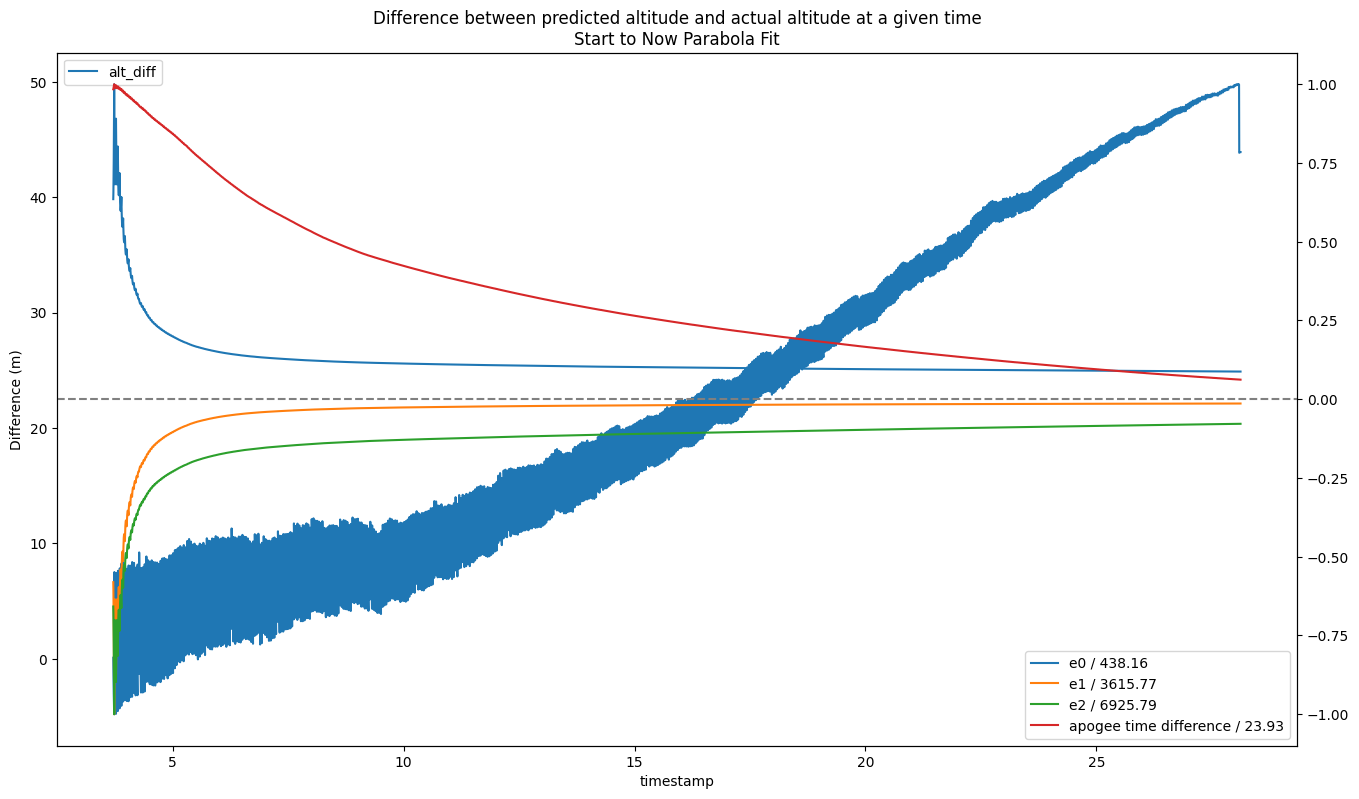

In [40]:
wdata = fdata.iloc[60:]

me0 = wdata['e0'].abs().max()
me1 = wdata['e1'].abs().max()
me2 = wdata['e2'].abs().max()

fig = wdata['alt_diff'].plot(figsize = (16, 9))
tx = fig.twinx()
tx.plot(wdata['e1'] / me1, label = f"e0 / {me0:.2f}")
tx.plot(wdata['e0'] / me0, label = f"e1 / {me1:.2f}")
tx.plot(wdata['e2'] / me2, label = f"e2 / {me2:.2f}")


madt = wdata['apogee_diff_t'].abs().max()
tx.plot(wdata['apogee_diff_t'] / madt, label = f"apogee time difference / {madt:.2f}")


tx.axhline(0, c = 'gray', linestyle = 'dashed')

fig.set_title("Difference between predicted altitude and actual altitude at a given time\nStart to Now Parabola Fit")
fig.set_ylabel("Difference (m)")
fig.legend()
tx.legend(loc = 'lower right')

In [41]:
fdata

,pressure (kPa),alt_m_asl,alt_m_agl,t,pred_alt,pred_apogee,pred_apogee_t,e0,e1,e2,apogee_diff,apogee_diff_t,alt_diff
timestamp,,,,,,,,,,,,,
3.502,83.018967,1648.553042,356.325308,3.502,356.325308,8732.387248,28.123,9.684855,3.391636e+01,1.187751e+02,-5019.503545,-0.067,-1.136868e-13
3.506,83.018967,1648.553042,356.325308,3.506,356.325308,356.325308,3.506,-4.836898,3.389698e+01,2.969378e+02,3356.558396,24.550,-1.136868e-13
3.509,82.812447,1668.766340,376.538606,3.509,376.538606,10000.000000,28.123,962537.980016,-6.745466e+06,1.181841e+07,-6287.116296,-0.067,9.425321e-09
3.513,82.812447,1668.766340,376.538606,3.513,378.404449,10000.000000,28.123,0.000021,2.176817e+03,-7.268752e+03,-6287.116296,-0.067,-1.865843e+00
3.516,82.812447,1668.766340,376.538606,3.516,377.858458,377.956225,3.520,-94275.183073,6.633446e+05,-1.166488e+06,3334.927479,24.536,-1.319853e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28.109,54.010750,4999.179527,3706.951794,28.109,3663.080861,3677.308718,26.567,-5.976495,3.175440e+02,-5.406389e+02,35.574986,1.489,4.387093e+01
28.113,54.010750,4999.179527,3706.951794,28.113,3663.063375,3677.351666,26.567,-5.976185,3.175357e+02,-5.405949e+02,35.532038,1.489,4.388842e+01
28.116,54.010750,4999.179527,3706.951794,28.116,3663.064240,3677.394576,26.567,-5.975875,3.175274e+02,-5.405509e+02,35.489128,1.489,4.388755e+01


In [27]:
actual_apogee_time

np.float64(28.056)

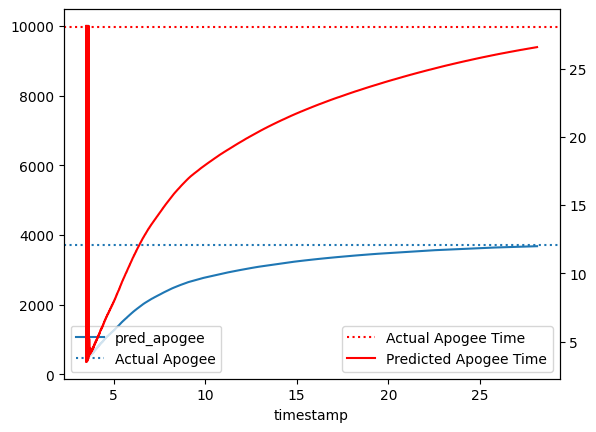

In [51]:
p = fdata[['pred_apogee']].plot()
p.axhline(actual_apogee, linestyle='dotted', label = 'Actual Apogee')
p.legend(loc = 'lower left')

tx = p.twinx()
tx.axhline(actual_apogee_time, linestyle='dotted', c = 'red', label = "Actual Apogee Time")
tx.plot(fdata['pred_apogee_t'], c = 'red', label = 'Predicted Apogee Time')

tx.legend(loc = 'lower right')

<Axes: xlabel='alt_m_agl'>

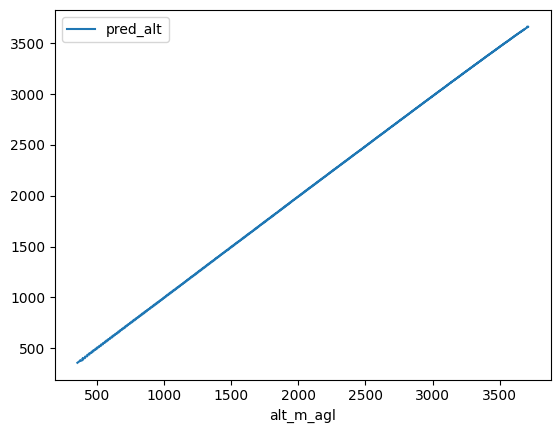

In [19]:
fdata[['pred_alt', 'alt_m_agl']].plot('alt_m_agl')